In [2]:
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt
from tqdm import trange, tqdm

### 定义模型

In [3]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(2, stride=2), nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [4]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t', X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


### 载入数据

In [5]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

(-0.5, 27.5, 27.5, -0.5)

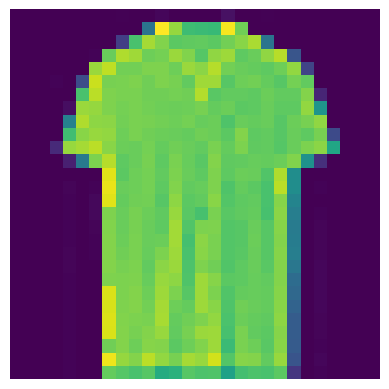

In [6]:
for X, y in train_iter:
    break
plt.imshow(X[0, 0])
plt.axis('off')

### 模型准确率评估

In [7]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval() # 网络变为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    
    num_accurate, num_sum = 0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            num_accurate += accuracy(net(X), y)
            num_sum += y.numel()
    return num_accurate / num_sum

### 模型训练

In [8]:
def train(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight) # xavier 防止梯度过大过小
    net.apply(init_weights)
    net.to(device)
    # 用 gpu 训练
    print('training on ', device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    # animator = d2l.Animator
    
    for epoch in trange(num_epochs, desc='Training', unit='epoch'):
        net.train()
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_accuracy, test_accuracy = evaluate_accuracy_gpu(net, train_iter, device='cuda'), evaluate_accuracy_gpu(net, test_iter, device='cuda')
    print(f'iter {epoch+1} / {num_epochs}, train_acc {train_accuracy:.3f}, test_acc {test_accuracy:.3f}')

In [9]:
lr, num_epochs = 0.5, 30
train(net, train_iter, test_iter, num_epochs, lr, device='cuda')

training on  cuda


Training: 100%|██████████| 30/30 [01:47<00:00,  3.60s/epoch]

iter 30 / 30, train_acc 0.867, test_acc 0.855
